<a href="https://colab.research.google.com/github/riyagoyal17/AI-Mafia-Machine-Learning/blob/main/2_hidden_images_using_sse_loss_and_ssim_metrics_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/data/smalldata1.zip

Streaming output truncated to the last 5000 lines.
  inflating: smalldata1/tacos/101.png  
  inflating: smalldata1/tacos/102.png  
  inflating: smalldata1/tacos/103.png  
  inflating: smalldata1/tacos/104.png  
  inflating: smalldata1/tacos/105.png  
  inflating: smalldata1/tacos/106.png  
  inflating: smalldata1/tacos/107.png  
  inflating: smalldata1/tacos/108.png  
  inflating: smalldata1/tacos/109.png  
  inflating: smalldata1/tacos/11.png  
  inflating: smalldata1/tacos/110.png  
  inflating: smalldata1/tacos/111.png  
  inflating: smalldata1/tacos/112.png  
  inflating: smalldata1/tacos/113.png  
  inflating: smalldata1/tacos/114.png  
  inflating: smalldata1/tacos/115.png  
  inflating: smalldata1/tacos/116.png  
  inflating: smalldata1/tacos/117.png  
  inflating: smalldata1/tacos/118.png  
  inflating: smalldata1/tacos/119.png  
  inflating: smalldata1/tacos/12.png  
  inflating: smalldata1/tacos/120.png  
  inflating: smalldata1/tacos/121.png  
  inflating: smalldata1/tacos/1

In [3]:
!pip install SSIM-PIL

In [4]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
#from keras.engine.topology import Container
from keras.engine.network import Network
from keras.layers import *
from keras import backend
from keras.models import Model,load_model
from keras.preprocessing import image
import keras.backend as K

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import random
import scipy.misc
from tqdm import *
from SSIM_PIL import compare_ssim
from PIL import Image
from google.colab import files


In [5]:
#DATA_DIR = "./data"
TRAIN_DIR = "/content/smalldata1"
#TEST_DIR = os.path.join(DATA_DIR, "test")
#print(os.listdir(TRAIN_DIR))
IMG_SHAPE = (64, 64)

def load_dataset_small(num_images_per_class_train=20, num_images_test=500):
    """Loads training and test datasets, from Tiny ImageNet Visual Recogition Challenge.

    Arguments:
        num_images_per_class_train: number of images per class to load into training dataset.
        num_images_test: total number of images to load into training dataset.
    """

    X_train = []
    X_test = []
    
    # Create training set.
    #print(os.listdir(TRAIN_DIR))
    
    for c in os.listdir("/content/smalldata1"):
        #print(c)
        c_dir = os.path.join("/content/smalldata1",c)
        c_imgs = os.listdir(c_dir)
        #print(c_imgs," ")
        random.shuffle(c_imgs)
        for img_name_i in c_imgs[0:num_images_per_class_train]:
            #print(img_name_i)
            img_i = image.load_img(os.path.join(c_dir, img_name_i))
            #img_i = np.asarray(img_i).reshape(64,64)

           # print(img_i.size[0] , img_i.size[1])
            x = image.img_to_array(img_i)
            X_train.append(x)
    random.shuffle(X_train)
  
    # Return train and test data as numpy arr
    return np.array(X_train)

In [6]:
# Load dataset.
X_train_orig = load_dataset_small()

# Normalize image vectors.
X_train = X_train_orig/255.

# Print statistics.
print ("Number of training examples = " + str(X_train.shape[0]))
print ("Number of test examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape)) # Should be (train_size, 64, 64, 3).

Number of training examples = 2020
Number of test examples = 2020
X_train shape: (2020, 64, 64, 3)


In [9]:
# We split training set into two halfs.
# First half is used for training as secret images, second half for cover images.

# S1: secret image1
input_S1 = X_train[0:X_train.shape[0] // 3]
# S2: secret image2
input_S2 = X_train[X_train.shape[0] // 3 : 2*(X_train.shape[0] // 3)]
# S3: secret image3
#input_S3 = X_train[2*(X_train.shape[0] // 4) : 3*(X_train.shape[0] // 4)]

# C: cover image
input_C = X_train[2*(X_train.shape[0] // 3):3*(X_train.shape[0] // 3)]

print(input_S1.shape)
print(input_C.shape)

(673, 64, 64, 3)
(673, 64, 64, 3)


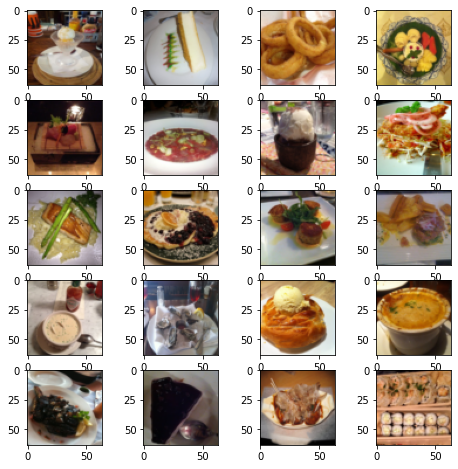

In [10]:
# Show sample images from the training dataset
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    # Randomly sample from training dataset
    img_idx = np.random.choice(X_train.shape[0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(X_train[img_idx])
plt.show()

In [11]:
# Variable used to weight the losses of the secret and cover images (See paper for more details)
beta = 1.0
    
# Loss for reveal network
def rev_loss(s_true, s_pred):
    # Loss for reveal network is: beta * |S-S'|
    return beta * K.sum(K.square(s_true - s_pred))

# Loss for the full model, used for preparation and hidding networks
def full_loss(y_true, y_pred):
    # Loss for the full model is: |C-C'| + beta * |S-S'|
    s1_true, s2_true, s3_true, c_true = y_true[...,0:3], y_true[...,3:6], y_true[...,6:9], y_true[...,9:12]
    s1_pred, s2_pred, s3_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6], y_pred[...,6:9], y_pred[...,9:12]

    s1_loss = beta * K.sum(K.square(s1_true - s1_pred))
    s2_loss = beta * K.sum(K.square(s2_true - s2_pred))
    s3_loss = beta * K.sum(K.square(s3_true - s3_pred))
    c_loss = K.sum(K.square(c_true - c_pred))
    
    return s1_loss + c_loss + s2_loss + s3_loss

def ssim_loss(y_true, y_pred):
  return  tf.reduce_mean(tf.image.ssim(y_true, y_pred, 2.0))

def ssim_l2_loss(y_true,y_pred):
  return 1-(tf.reduce_mean(tf.image.ssim(y_true,y_pred,2.0)))#+ beta*(K.sum(K.square(y_true - y_pred)))

def full_ssim_l2_loss(y_true,y_pred):

  s_true, c_true = y_true[...,0:3], y_true[...,3:6]
  s_pred, c_pred = y_pred[...,0:3], y_pred[...,3:6]

  #s_loss = rev_loss(s_true, s_pred)
  s_loss =  1 - (tf.reduce_mean(tf.image.ssim(s_true,s_pred,2.0))) #+ beta*(K.sum(K.square(s_true - s_pred)))
  c_loss =  1 - (tf.reduce_mean(tf.image.ssim(c_true,c_pred,2.0))) #+ (K.sum(K.square(c_true - c_pred)))

  return s_loss + c_loss

In [16]:
# Returns the encoder as a Keras model, composed by Preparation and Hiding Networks.
def make_encoder(input_size):
    input_S1 = Input(shape=(input_size))
    input_S2 = Input(shape=(input_size))
    #input_S3 = Input(shape=(input_size))
    input_C= Input(shape=(input_size))

    # Preparation Network for Secret Image 2
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_1')(input_S1)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_1')(input_S1)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_1')(input_S1)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_1')(x)
    x1 = concatenate([x3, x4, x5])

    # Preparation Network for Secret Image 2
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_2')(input_S2)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_2')(input_S2)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_2')(input_S2)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_2')(x)
    x2 = concatenate([x3, x4, x5])

    # Preparation Network for Secret Image 3
    '''
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_3x3_3')(input_S3)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_4x4_3')(input_S3)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep0_5x5_3')(input_S3)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_3x3_3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_4x4_3')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_prep1_5x5_3')(x)
    x3_1 = concatenate([x3, x4, x5])
    '''
    # Prep Network outputs concatenated to the encoded cover
    x = concatenate([input_C, x1, x2])
    
    # Hiding network 
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid0_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_hid4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_hid5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_Cprime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_C')(x)
    
    return Model(inputs=[input_S1, input_S2,input_C],
                 outputs=output_Cprime,
                 name = 'Encoder')

In [17]:
# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder1(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise1')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_1')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_1')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_1')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_1')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_1')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5_1')(x)
    x = concatenate([x3, x4, x5])
    
    output_S1prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S1')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S1prime)
    else:
        return Network(inputs=reveal_input,
                         outputs=output_S1prime)
        
# Returns the decoder as a Keras model, composed by the Reveal Network
def make_decoder2(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise2')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3_2')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4_2')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5_2')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3_2')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4_2')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5_2')(x)
    x = concatenate([x3, x4, x5])
    
    output_S2prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S2')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S2prime)
    else:
        return Network(inputs=reveal_input,
                         outputs=output_S2prime)

# Returns the decoder as a Keras model, composed by the Reveal Network
'''
def make_decoder3(input_size, fixed=False):
    
    # Reveal network
    reveal_input = Input(shape=(input_size))
    
    # Adding Gaussian noise with 0.01 standard deviation.
    input_with_noise = GaussianNoise(0.01, name='output_C_noise2')(reveal_input)
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_3x3')(input_with_noise)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_4x4')(input_with_noise)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev0_5x5')(input_with_noise)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev1_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev2_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev3_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_3x3')(x)
    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding='same', activation='relu', name='conv_rev4_4x4')(x)
    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding='same', activation='relu', name='conv_rev5_5x5')(x)
    x = concatenate([x3, x4, x5])
    
    output_S3prime = Conv2D(3, (3, 3), strides = (1, 1), padding='same', activation='relu', name='output_S3')(x)
    
    if not fixed:
        return Model(inputs=reveal_input,
                     outputs=output_S3prime)
    else:
        """return Container(inputs=reveal_input,
                         outputs=output_S2prime,
                         name = 'DecoderFixed')"""
        return Network(inputs=reveal_input,
                         outputs=output_S3prime)
'''

'\ndef make_decoder3(input_size, fixed=False):\n    \n    # Reveal network\n    reveal_input = Input(shape=(input_size))\n    \n    # Adding Gaussian noise with 0.01 standard deviation.\n    input_with_noise = GaussianNoise(0.01, name=\'output_C_noise2\')(reveal_input)\n    \n    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding=\'same\', activation=\'relu\', name=\'conv_rev0_3x3\')(input_with_noise)\n    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding=\'same\', activation=\'relu\', name=\'conv_rev0_4x4\')(input_with_noise)\n    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding=\'same\', activation=\'relu\', name=\'conv_rev0_5x5\')(input_with_noise)\n    x = concatenate([x3, x4, x5])\n    \n    x3 = Conv2D(50, (3, 3), strides = (1, 1), padding=\'same\', activation=\'relu\', name=\'conv_rev1_3x3\')(x)\n    x4 = Conv2D(10, (4, 4), strides = (1, 1), padding=\'same\', activation=\'relu\', name=\'conv_rev1_4x4\')(x)\n    x5 = Conv2D(5, (5, 5), strides = (1, 1), padding=\'same\', activation

In [18]:
# Full model.
def make_model(input_size):
    input_S1 = Input(shape=(input_size))
    input_S2 = Input(shape=(input_size))
    #input_S3 = Input(shape=(input_size))
    input_C= Input(shape=(input_size))
    
    encoder = make_encoder(input_size)
    
    decoder1 = make_decoder1(input_size)
    decoder1.compile(optimizer='adam', loss=rev_loss,metrics = ssim_loss)
    decoder1.trainable = False

    decoder2 = make_decoder2(input_size)
    decoder2.compile(optimizer='adam', loss=rev_loss,metrics = ssim_loss)
    decoder2.trainable = False
    '''
    decoder3 = make_decoder3(input_size)
    decoder3.compile(optimizer='adam', loss=rev_loss,metrics = ssim_loss)
    decoder3.trainable = False
    '''
    output_Cprime = encoder([input_S1, input_S2, input_C])
    output_S1prime = decoder1(output_Cprime)
    output_S2prime = decoder2(output_Cprime)
    #output_S3prime = decoder3(output_Cprime)

    autoencoder1 = Model(inputs=[input_S1, input_S2, input_C],
                        outputs=concatenate([output_S1prime, output_S2prime, output_Cprime]))
    autoencoder1.compile(optimizer='adam', loss=full_loss,metrics = ssim_loss)
    
    # autoencoder2 = Model(inputs=[input_S1, input_S2, input_C],
    #                     outputs=concatenate([output_S2prime, output_Cprime]))
    # autoencoder2.compile(optimizer='adam', loss=full_loss)


    return encoder, decoder1, decoder2,  autoencoder1

In [19]:
encoder_model, reveal_model1, reveal_model2, autoencoder_model = make_model(input_S1.shape[1:])

In [20]:
def lr_schedule(epoch_idx):
    if epoch_idx < 200:
        return 0.001
    elif epoch_idx < 400:
        return 0.0003
    elif epoch_idx < 600:
        return 0.0001
    else:
        return 0.00003

In [24]:
BATCH_SIZE = 32
loss_history = []
rev1_history = []
rev2_history = []
#rev3_history = []
m = input_S1.shape[0]
for epoch in range(400):
    np.random.shuffle(input_S1)
    np.random.shuffle(input_S2)
    #np.random.shuffle(input_S3)
    np.random.shuffle(input_C)
    
    t = tqdm(range(0, input_S1.shape[0], BATCH_SIZE),mininterval=0)
    ae_loss = []
    rev_loss1 = []
    rev_loss2 = []
    #rev_loss3 = []
    for idx in t:
        
        batch_S1 = input_S1[idx:min(idx + BATCH_SIZE, m)]
        batch_S2 = input_S2[idx:min(idx + BATCH_SIZE, m)]
        #batch_S3 = input_S3[idx:min(idx + BATCH_SIZE, m)]
        batch_C = input_C[idx:min(idx + BATCH_SIZE, m)]
        
        C_prime = encoder_model.predict([batch_S1, batch_S2, batch_C])
        
        ae_loss.append(autoencoder_model.train_on_batch(x=[batch_S1, batch_S2,batch_C],
                                                   y=np.concatenate((batch_S1, batch_S2, batch_C),axis=3)))
        rev_loss1.append(reveal_model1.train_on_batch(x=C_prime,
                                              y=batch_S1))
        rev_loss2.append(reveal_model2.train_on_batch(x=C_prime,
                                              y=batch_S2))
        #rev_loss3.append(reveal_model3.train_on_batch(x=C_prime,
        #                                      y=batch_S3))
        
        # Update learning rate
        K.set_value(autoencoder_model.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model1.optimizer.lr, lr_schedule(epoch))
        K.set_value(reveal_model2.optimizer.lr, lr_schedule(epoch))
        #K.set_value(reveal_model3.optimizer.lr, lr_schedule(epoch))
        
        t.set_description('Epoch {} | Batch: {:3} of {}. Loss AE {:10.2f} | Loss Rev {:10.2f} | Loss Rev2 {:10.2f}'.format(epoch + 1, idx, m, np.mean(ae_loss), np.mean(rev_loss1), np.mean(rev_loss2)))
    
    autoencoder_model.save_weights('models/model_A21_'+str(epoch))
    
    loss_history.append(np.mean(ae_loss))
    rev1_history.append(np.mean(rev_loss1))
    rev2_history.append(np.mean(rev_loss2))
    #rev3_history.append(np.mean(rev_loss3))

Streaming output truncated to the last 5000 lines.
Epoch 292 | Batch: 192 of 673. Loss AE    2432.44 | Loss Rev     567.88 | Loss Rev2     519.53:  27%|██▋       | 6/22 [00:04<00:11,  1.42it/s]
Epoch 292 | Batch: 192 of 673. Loss AE    2432.44 | Loss Rev     567.88 | Loss Rev2     519.53:  32%|███▏      | 7/22 [00:04<00:10,  1.43it/s]
Epoch 292 | Batch: 224 of 673. Loss AE    2437.28 | Loss Rev     570.01 | Loss Rev2     521.11:  32%|███▏      | 7/22 [00:05<00:10,  1.43it/s]
Epoch 292 | Batch: 224 of 673. Loss AE    2437.28 | Loss Rev     570.01 | Loss Rev2     521.11:  36%|███▋      | 8/22 [00:05<00:09,  1.43it/s]
Epoch 292 | Batch: 256 of 673. Loss AE    2429.96 | Loss Rev     572.14 | Loss Rev2     520.27:  36%|███▋      | 8/22 [00:06<00:09,  1.43it/s]
Epoch 292 | Batch: 256 of 673. Loss AE    2429.96 | Loss Rev     572.14 | Loss Rev2     520.27:  41%|████      | 9/22 [00:06<00:09,  1.43it/s]
Epoch 292 | Batch: 288 of 673. Loss AE    2409.73 | Loss Rev     566.90 | Loss Rev2     521

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

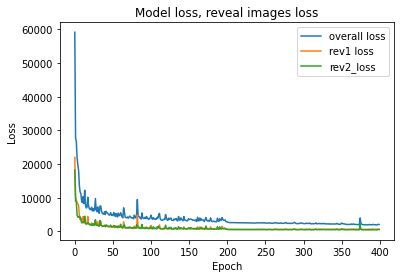

In [26]:
## Plot loss through epochs 
plt.plot(loss_history,label = 'overall loss')
plt.plot(rev1_history,label = 'rev1 loss')
plt.plot(rev2_history,label = 'rev2_loss')
#plt.plot(rev3_history,label = 'rev3_loss')
plt.title('Model loss, reveal images loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig("2_hiddeen_loss_400_sse.png")
files.download("2_hiddeen_loss_400_sse.png") 
plt.show()
#plt.show()

In [28]:
# Retrieve decoded predictions.
decoded = autoencoder_model.predict([input_S1, input_S2, input_C])
decoded_S1, decoded_S2, decoded_C = decoded[...,0:3], decoded[...,3:6], decoded[...,6:9]

# Get absolute difference between the outputs and the expected values.
diff_S1, diff_S2, diff_C = np.abs(decoded_S1 - input_S1), np.abs(decoded_S2 - input_S2), np.abs(decoded_C - input_C) 

In [50]:
def pixel_errors(input_S1, input_S2, input_C, decoded_S1, decoded_S2,decoded_C):
    """Calculates mean of Sum of Squared Errors per pixel for cover and secret images. """
    see_S1pixel = np.sqrt(np.mean(np.square(255*(input_S1 - decoded_S1))))
    see_S2pixel = np.sqrt(np.mean(np.square(255*(input_S2 - decoded_S2))))
    #see_S3pixel = np.sqrt(np.mean(np.square(255*(input_S3 - decoded_S3))))
    see_Cpixel = np.sqrt(np.mean(np.square(255*(input_C - decoded_C))))
    
    return see_S1pixel, see_S2pixel,see_Cpixel

def pixel_histogram(diff_S1, diff_S2,  diff_C):
    """Calculates histograms of errors for cover and secret image. """
    diff_S1flat = diff_S1.flatten()
    diff_S2flat = diff_S2.flatten()
    #diff_S3flat = diff_S3.flatten()
    diff_Cflat = diff_C.flatten()
    
    fig = plt.figure(figsize=(40, 20))
    a=fig.add_subplot(2,2,1)
        
    imgplot = plt.hist(255* diff_Cflat, 100, alpha=0.75, facecolor='red')
    a.set_title('Distribution of error in the Cover image.')
    plt.axis([0, 250, 0, 0.2])
    
    a=fig.add_subplot(2,2,2)
    imgplot = plt.hist(255* diff_S1flat, 100, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image1.')
    plt.axis([0, 250, 0, 0.2])

    a=fig.add_subplot(2,2,3)
    imgplot = plt.hist(255* diff_S2flat, 100, alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image2.')
    plt.axis([0, 250, 0, 0.2])
    '''
    a=fig.add_subplot(2,2,4)
    imgplot = plt.hist(255* diff_S3flat, 100,alpha=0.75, facecolor='red')
    a.set_title('Distribution of errors in the Secret image3.')
    plt.axis([0, 250, 0, 0.2])
    '''
    plt.savefig("2_hiddeen_distribution_400_ssim.png")
    files.download("2_hiddeen_distribution_400_ssim.png") 
    plt.show()

In [41]:
   # Read images from file.
  #  im1 = tf.decode_png('path/to/im1.png')
   # im2 = tf.decode_png('path/to/im2.png')
    # Compute SSIM over tf.uint8 Tensors.
ssim1 = tf.image.ssim(input_S1, decoded_S1, max_val=255, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)

    # Compute SSIM over tf.float32 Tensors.
im1 = tf.image.convert_image_dtype(input_S1, tf.float32)
im2 = tf.image.convert_image_dtype(decoded_S1, tf.float32)
ssim2 = tf.image.ssim(im1, im2, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    # ssim1 and ssim2 both have type tf.float32 and are almost equal.

print("secret1")
print("ssim1  = ",ssim1)
print("ssim2 = ",ssim2)

ssim1 = tf.image.ssim(input_S2, decoded_S2, max_val=255, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)

    # Compute SSIM over tf.float32 Tensors.
im1 = tf.image.convert_image_dtype(input_S2, tf.float32)
im2 = tf.image.convert_image_dtype(decoded_S2, tf.float32)
ssim2 = tf.image.ssim(im1, im2, max_val=1.0, filter_size=11, filter_sigma=1.5, k1=0.01, k2=0.03)
    # ssim1 and ssim2 both have type tf.float32 and are almost equal.

print("secret2")
print("ssim1  = ",ssim1)
print("ssim2 = ",ssim2)

secret1
ssim1  =  tf.Tensor(
[0.9994934  0.9996821  0.9998355  0.99979967 0.99979305 0.999805
 0.9993098  0.9997649  0.9997747  0.9998602  0.9996924  0.9995912
 0.9997621  0.9997198  0.999887   0.99983025 0.9996483  0.999775
 0.9998526  0.9998989  0.9997898  0.99941844 0.9997818  0.9998267
 0.9998104  0.9998851  0.99980164 0.99982977 0.99983746 0.9997923
 0.99978393 0.99985814 0.99980706 0.99975306 0.9996882  0.99937296
 0.9996958  0.99984694 0.9998527  0.9997423  0.9998583  0.99991965
 0.9997876  0.9998483  0.99931234 0.9998067  0.99975795 0.9998093
 0.9998744  0.99981904 0.9998463  0.99980617 0.99981594 0.9996357
 0.9997652  0.999744   0.99980354 0.9998171  0.9998472  0.9998452
 0.99974054 0.9998369  0.9998706  0.9998055  0.99982613 0.9997445
 0.99987555 0.9998047  0.99979    0.9998124  0.9998214  0.9996893
 0.9997875  0.99980855 0.99975103 0.99984    0.99985236 0.99982136
 0.9994461  0.99979424 0.99983305 0.9993445  0.9997322  0.999542
 0.9997645  0.99976176 0.9996312  0.9997987  0.

In [42]:

   # Read images from file.
  #  im1 = tf.decode_png('path/to/im1.png')
   # im2 = tf.decode_png('path/to/im2.png')
    # Compute SSIM over tf.uint8 Tensors.
ssim1 = tf.image.ssim(input_C, decoded_C, max_val=255, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)

    # Compute SSIM over tf.float32 Tensors.
im1 = tf.image.convert_image_dtype(input_C, tf.float32)
im2 = tf.image.convert_image_dtype(decoded_C, tf.float32)
ssim2 = tf.image.ssim(im1, im2, max_val=1.0, filter_size=11,filter_sigma=1.5, k1=0.01, k2=0.03)
    # ssim1 and ssim2 both have type tf.float32 and are almost equal.
print("cover")
print("ssim1  = ",ssim1)
print("ssim2 = ",ssim2)

cover
ssim1  =  tf.Tensor(
[0.99966806 0.99957114 0.9996926  0.9994506  0.99946326 0.99969417
 0.9994111  0.9995618  0.99971676 0.9998605  0.9992581  0.9993739
 0.9992802  0.99937963 0.99960536 0.99984974 0.9993889  0.99984354
 0.9997325  0.9996121  0.9996734  0.9988517  0.99980587 0.99950475
 0.9996493  0.99985677 0.9990339  0.9993462  0.99967194 0.9994564
 0.99983215 0.9981117  0.99941015 0.9995777  0.9998091  0.99824697
 0.9993527  0.9994879  0.99992007 0.99958324 0.9997874  0.9997807
 0.9997422  0.99900407 0.99969774 0.9996758  0.9993846  0.9997916
 0.9998242  0.9992958  0.99962306 0.9992268  0.9992196  0.99931496
 0.9995962  0.9998072  0.9997553  0.99956065 0.9993298  0.9992056
 0.9997361  0.99972564 0.9998236  0.99951077 0.999657   0.9993866
 0.99978    0.99925536 0.99983364 0.99945045 0.9997017  0.9990902
 0.99975204 0.9994963  0.999311   0.9994678  0.9997453  0.99929506
 0.99989843 0.9998087  0.9995241  0.9995988  0.9991181  0.9996597
 0.99926275 0.9997472  0.9997313  0.9998471

In [43]:
# Print pixel-wise average errors in a 256 scale.
S1_error, S2_error, C_error = pixel_errors(input_S1, input_S2, input_C,decoded_S1, decoded_S2, decoded_C)

print ("S1 error per pixel [0, 255]:", S1_error)
print ("S2 error per pixel [0, 255]:", S2_error)
#print ("S3 error per pixel [0, 255]:", S3_error)
print ("C error per pixel [0, 255]:", C_error)

S1 error per pixel [0, 255]: 13.966153
S2 error per pixel [0, 255]: 12.952049
C error per pixel [0, 255]: 17.465307


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

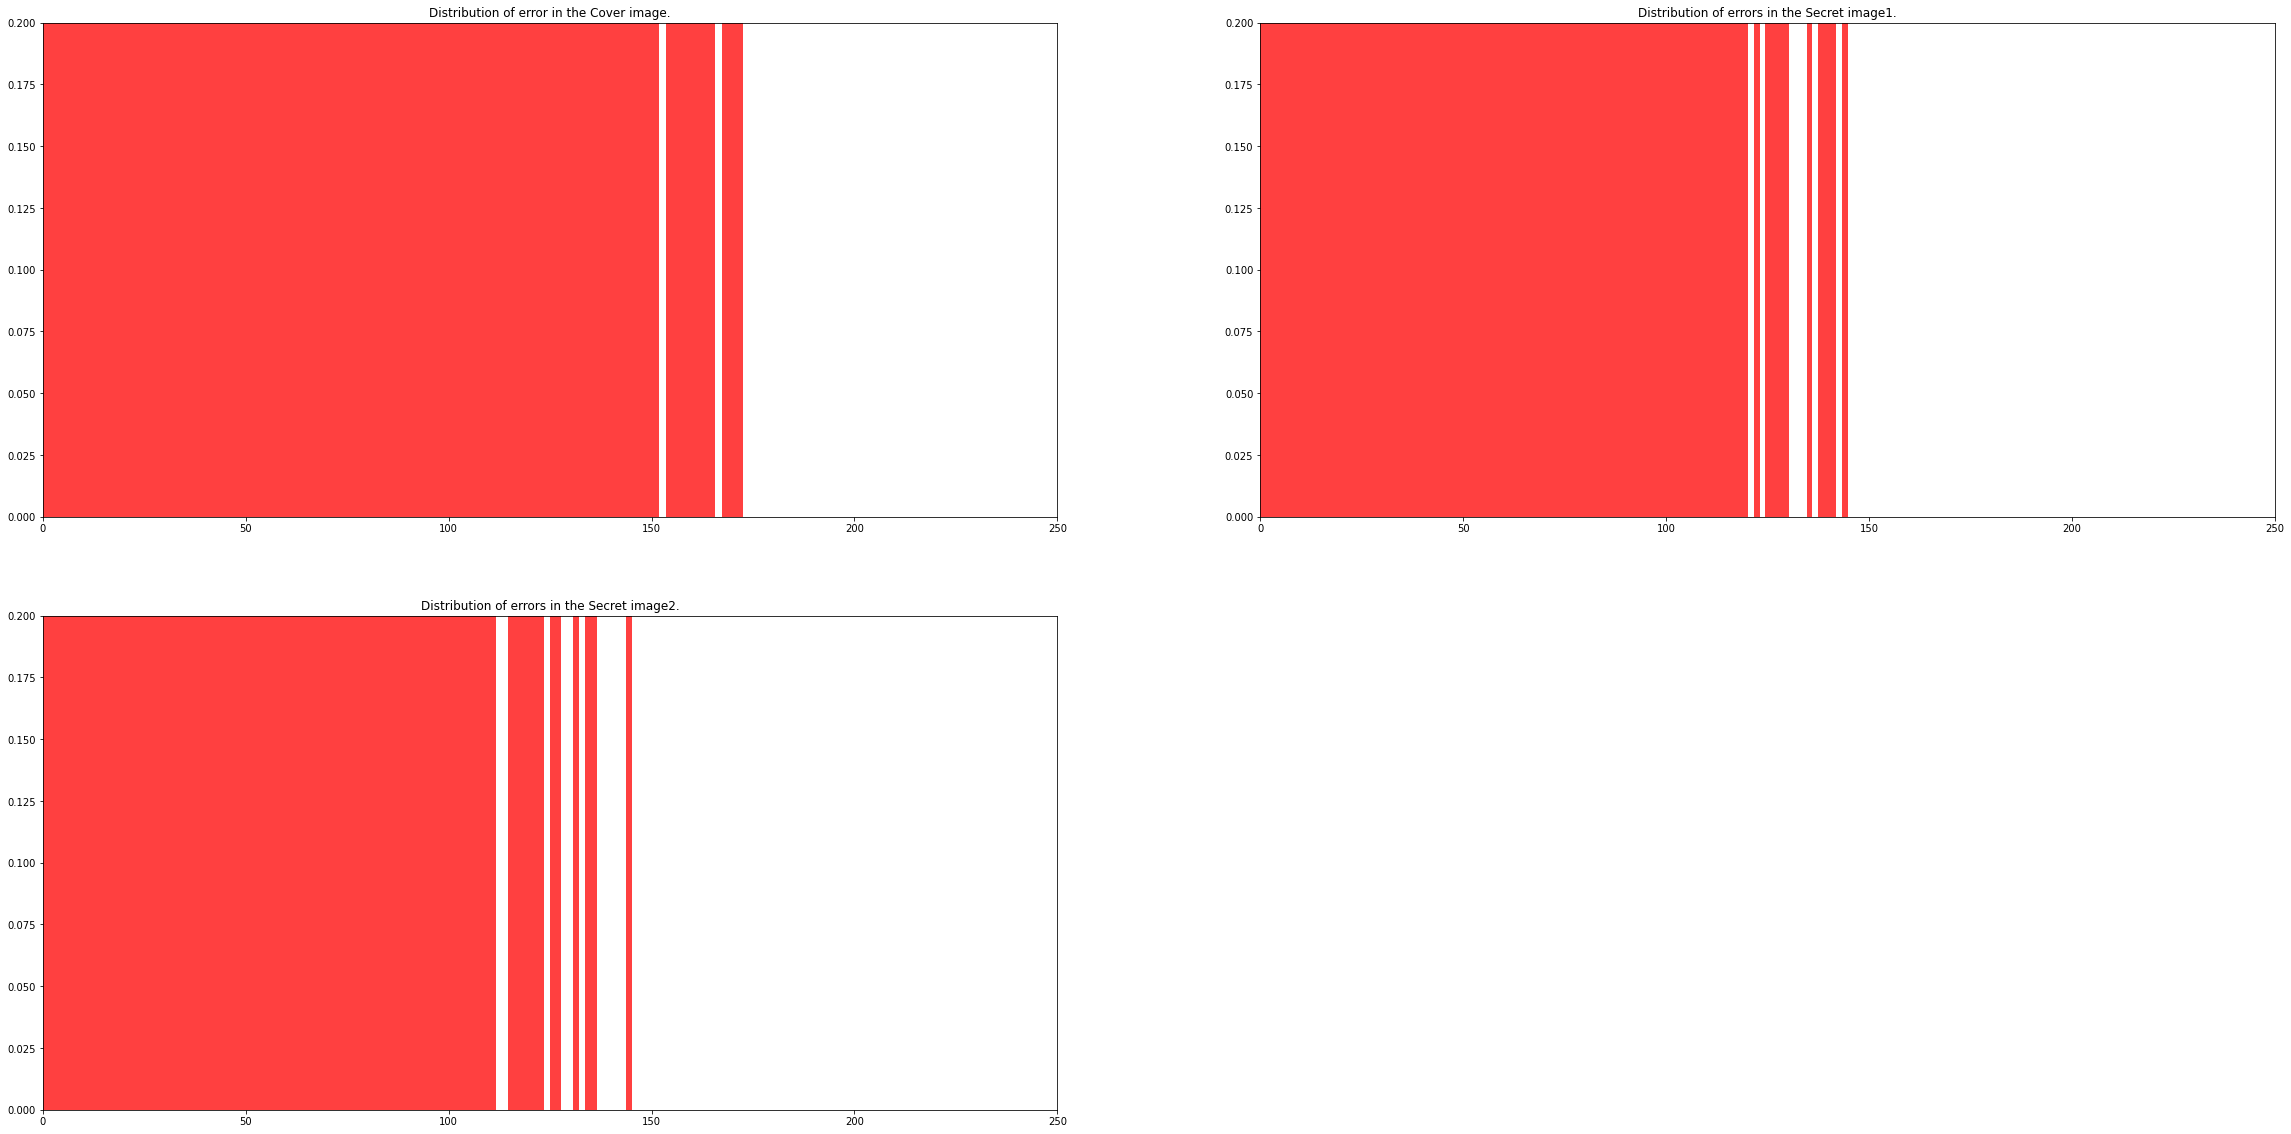

In [51]:
# Plot distribution of errors in cover and secret images.
pixel_histogram(diff_S1, diff_S2,diff_C)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No module named 'pyopencl'
cover :  0.8663185868935817
No module named 'pyopencl'
secret1 :  0.8460422972337369
No module named 'pyopencl'
secret2 :  0.9342099315112034


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No module named 'pyopencl'
cover :  0.8094727363026137
No module named 'pyopencl'
secret1 :  0.7737069086425279
No module named 'pyopencl'
secret2 :  0.9263187074491483
No module named 'pyopencl'
cover :  0.6935642253874739
No module named 'pyopencl'
secret1 :  0.8733837872591236
No module named 'pyopencl'
secret2 :  0.8546538640292155


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No module named 'pyopencl'
cover :  0.8217804402987343
No module named 'pyopencl'
secret1 :  0.7875637855648262
No module named 'pyopencl'
secret2 :  0.9200345426754547
No module named 'pyopencl'
cover :  0.7548915673112654
No module named 'pyopencl'
secret1 :  0.8385228460941421
No module named 'pyopencl'
secret2 :  0.8840219103056405


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


No module named 'pyopencl'
cover :  0.8807624258504062
No module named 'pyopencl'
secret1 :  0.7976844021608416
No module named 'pyopencl'
secret2 :  0.9261913344672805


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

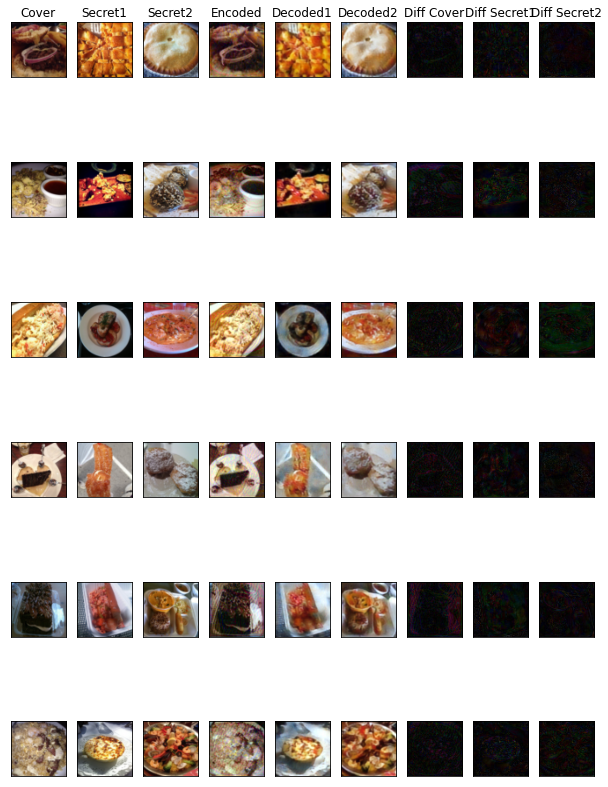

In [49]:
# Configs for results display

# Show images in gray scale
SHOW_GRAY = False
# Show difference bettwen predictions and ground truth.
SHOW_DIFF = True

# Diff enhance magnitude
ENHANCE = 1

# Number of secret and cover pairs to show.
n = 6

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

def show_image(img, n_rows, n_col, idx, gray=False, first_row=False, title=None):
    ax = plt.subplot(n_rows, n_col, idx)
    if gray:
        plt.imshow(rgb2gray(img), cmap = plt.get_cmap('gray'))
    else:
        plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if first_row:
        plt.title(title)

plt.figure(figsize=(14, 15))
rand_indx = [random.randint(0, 500) for x in range(n)]
# for i, idx in enumerate(range(0, n)):
for i, idx in enumerate(rand_indx):
    n_col = 12 if SHOW_DIFF else 8
    
    show_image(input_C[idx], n, n_col, i * n_col + 1, gray=SHOW_GRAY, first_row=i==0, title='Cover')

    show_image(input_S1[idx], n, n_col, i * n_col + 2, gray=SHOW_GRAY, first_row=i==0, title='Secret1')

    show_image(input_S2[idx], n, n_col, i * n_col + 3, gray=SHOW_GRAY, first_row=i==0, title='Secret2')

    #show_image(input_S3[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Secret3')
    
    show_image(decoded_C[idx], n, n_col, i * n_col + 4, gray=SHOW_GRAY, first_row=i==0, title='Encoded')
    
    show_image(decoded_S1[idx], n, n_col, i * n_col + 5, gray=SHOW_GRAY, first_row=i==0, title='Decoded1')

    show_image(decoded_S2[idx], n, n_col, i * n_col + 6, gray=SHOW_GRAY, first_row=i==0, title='Decoded2')

    #show_image(decoded_S3[idx], n, n_col, i * n_col + 8, gray=SHOW_GRAY, first_row=i==0, title='Decoded3')

    
    if SHOW_DIFF:

      show_image(np.multiply(diff_C[idx], ENHANCE), n, n_col, i * n_col + 7, gray=SHOW_GRAY, first_row=i==0, title='Diff Cover')
        
      show_image(np.multiply(diff_S1[idx], ENHANCE), n, n_col, i * n_col + 8, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret1')

      show_image(np.multiply(diff_S2[idx], ENHANCE), n, n_col, i * n_col + 9, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret2')

      #show_image(np.multiply(diff_S3[idx], ENHANCE), n, n_col, i * n_col + 12, gray=SHOW_GRAY, first_row=i==0, title='Diff Secret3')

    cover = Image.fromarray((input_C[idx] * 255).astype(np.uint8))
    cover_decode = Image.fromarray((decoded_C[idx] * 255).astype(np.uint8))
    valuec = compare_ssim(cover,cover_decode ) # Compare images using OpenCL by default
    print("cover : ",valuec)

    secret = Image.fromarray((input_S1[idx] * 255).astype(np.uint8))
    secret_decode = Image.fromarray((decoded_S1[idx] * 255).astype(np.uint8))
    values = compare_ssim(secret,secret_decode ) # Compare images using OpenCL by default
    print("secret1 : ",values)

    secret = Image.fromarray((input_S2[idx] * 255).astype(np.uint8))
    secret_decode = Image.fromarray((decoded_S2[idx] * 255).astype(np.uint8))
    values = compare_ssim(secret,secret_decode ) # Compare images using OpenCL by default
    print("secret2 : ",values)



plt.savefig("output_3_hidden_using_metrics_ssim_loss.png")
files.download("output_3_hidden_using_metrics_ssim_loss.png") 
plt.show()

In [56]:
model_json = autoencoder_model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
autoencoder_model.save_weights("models.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from keras.models import model_from_json
json_file = open('/content/2_hidden_image_model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights("2_hidden_image_model.h5")

In [57]:
autoencoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
Encoder (Functional)            (None, 64, 64, 3)    391158      input_7[0][0]                    
                                                                 input_8[0][0]              

In [58]:
encoder_model.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv_prep0_3x3_1 (Conv2D)       (None, 64, 64, 50)   1400        input_10[0][0]                   
__________________________________________________________________________________________________
conv_prep0_4x4_1 (Conv2D)       (None, 64, 64, 10)   490         input_10[0][0]                   
____________________________________________________________________________________________

In [59]:
reveal_model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
output_C_noise1 (GaussianNoise) (None, 64, 64, 3)    0           input_13[0][0]                   
__________________________________________________________________________________________________
conv_rev0_3x3_1 (Conv2D)        (None, 64, 64, 50)   1400        output_C_noise1[0][0]            
__________________________________________________________________________________________________
conv_rev0_4x4_1 (Conv2D)        (None, 64, 64, 10)   490         output_C_noise1[0][0]            
______________________________________________________________________________________________

In [60]:
reveal_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
output_C_noise2 (GaussianNoise) (None, 64, 64, 3)    0           input_14[0][0]                   
__________________________________________________________________________________________________
conv_rev0_3x3_2 (Conv2D)        (None, 64, 64, 50)   1400        output_C_noise2[0][0]            
__________________________________________________________________________________________________
conv_rev0_4x4_2 (Conv2D)        (None, 64, 64, 10)   490         output_C_noise2[0][0]            
____________________________________________________________________________________________